# Analyzing Reddit Responses to Pope Leo XIV

#### Author: Adam Richman

Welcome to my analysis of Reddit responses to Pope Leo XIV, the first American Pope! In this Jupyter notebook, I use Python to scrape Reddit posts and comments mentioning him, then apply sentiment analysis to classify opinions as **in favor**, **against**, or **neutral**.

## Introduction
Pope Leo XIV’s election as the first American Pope has sparked lively discussions online. Why Reddit? It’s a vibrant platform where people share unfiltered opinions. Here, I’ll scrape posts and comments about him, analyze their sentiment, and uncover what Reddit users really think. Expect clear explanations, cool visuals, and some surprising insights!

## Setup and imports
First, let’s set up our tools. We’ll use several Python libraries to make this happen:
- Selenium: Scrapes Reddit by simulating a browser.
- Pandas: Organizes our data into tables.
- NLTK (VADER): Analyzes sentiment in comments.
- Matplotlib & WordCloud: Creates visuals like charts and word clouds.

In [18]:
# install dependencies (run this cell once) (uncomment to run)
#!pip install selenium pandas nltk matplotlib wordcloud

In [19]:
# import libraries
import time
import pandas as pd
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
import nltk
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from nltk.sentiment import SentimentIntensityAnalyzer
from urllib.parse import quote_plus

# download NLTK VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arichman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Initialize selenium webdriver
We’re using Selenium to scrape Reddit in a “headless” Chrome browser - it runs silently in the background. A custom user-agent helps us avoid being blocked by Reddit’s anti-scraping measures.

In [20]:
# configure headless Chrome with custom User-Agent to avoid blocks
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                     'AppleWebKit/537.36 (KHTML, like Gecko) '
                     'Chrome/112.0.0.0 Safari/537.36')

# initialize WebDriver
driver = webdriver.Chrome(options=options)

## Scrape reddit posts
Next, we scrape posts mentioning "Pope Leo XIV" and "Pope Leo" from old.reddit.com. Why the old version? It’s simpler and more reliable for scraping.

In [21]:
# function to fetch posts from old.reddit.com
def get_posts_old_reddit(query, limit=100):
    base_url = 'https://old.reddit.com/search?q=' + quote_plus(query) + '&t=all&type=link'
    url = base_url
    data = []
    pages_without_posts = 0  # track pages with no valid posts
    max_pages_without_posts = 3  # stop after 3 empty pages

    while len(data) < limit and url and pages_without_posts < max_pages_without_posts:
        driver.get(url)
        time.sleep(2)
        print(f"Loaded URL: {driver.current_url}")
        posts = driver.find_elements(By.CSS_SELECTOR, 'div.search-result')
        print(f"Found {len(posts)} posts on this page")
        valid_posts_found = False
        for i, post in enumerate(posts):
            if len(data) >= limit:
                break
            try:
                # log HTML of first few posts for debugging
                if i < 3:
                    print(f"Post {i+1} HTML: {post.get_attribute('outerHTML')[:200]}...")
                title_elem = post.find_element(By.CSS_SELECTOR, 'a.search-title')
                title = title_elem.text
                link = title_elem.get_attribute('href')
                try:
                    subreddit = post.find_element(By.CSS_SELECTOR, 'a.search-subreddit-link').text
                except NoSuchElementException:
                    subreddit = "N/A"
                try:
                    score = post.find_element(By.CSS_SELECTOR, 'span.search-score').text
                except NoSuchElementException:
                    score = "N/A"
                # try to extract post_id from link
                post_id = "N/A"
                match = re.search(r'/comments/(\w+)/', link)
                if match:
                    post_id = match.group(1)  
                data.append({
                    'title': title,
                    'subreddit': subreddit,
                    'upvotes': score,
                    'link': link,
                    'post_id': post_id
                })
                print(f"Collected post {i+1}: {title} (ID: {post_id})")
                valid_posts_found = True
            except Exception as e:
                print(f"Skipped post {i+1}: {e}")
                continue
        if not valid_posts_found:
            pages_without_posts += 1
            print(f"No valid posts found on page {pages_without_posts}/{max_pages_without_posts}")
        else:
            pages_without_posts = 0
        try:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1)
            next_btn = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'a[rel*="next"]'))
            )
            print("Found 'next' button with href:", next_btn.get_attribute('href'))
            url = next_btn.get_attribute('href')
        except Exception as e:
            print(f"Could not find 'next' button within 10 seconds: {e}")
            if len(data) < limit and valid_posts_found and data:
                last_post_id = data[-1]['post_id']
                if last_post_id != "N/A":
                    current_count = len(data)
                    url = base_url + f"&count={current_count}&after=t3_{last_post_id}"
                    print(f"Falling back to constructed URL: {url}")
                else:
                    print("Cannot construct URL: No valid post_id")
                    url = None
            else:
                print("No valid posts found or no more pages available")
                url = None

    print(f"Collected {len(data)} posts for '{query}'")
    return data

# fetch 100 posts per query
target_limit = 100
posts_xiv = get_posts_old_reddit('Pope Leo XIV', limit=target_limit)
posts_leo = get_posts_old_reddit('Pope Leo', limit=target_limit)

# merge and dedupe
all_posts = {p['link']: p for p in (posts_xiv + posts_leo)}
data = list(all_posts.values())
df_posts = pd.DataFrame(data)
df_posts.head()

Loaded URL: https://old.reddit.com/search?q=Pope+Leo+XIV&t=all&type=link
Found 25 posts on this page
Post 1 HTML: <div class=" search-result search-result-link has-thumbnail has-linkflair " data-fullname="t3_1khvnpq"><a href="/r/interesting/comments/1khvnpq/the_new_pope_leo_xiv/" class="may-blank thumbnail "><img...
Collected post 1: The new Pope Leo XIV (ID: 1khvnpq)
Post 2 HTML: <div class=" search-result search-result-link has-thumbnail has-linkflair linkflair-news " data-fullname="t3_1khvk6w"><a href="/r/Philippines/comments/1khvk6w/pope_leo_xiv_megathread/" class="may-blan...
Collected post 2: Pope Leo XIV Megathread (ID: 1khvk6w)
Post 3 HTML: <div class=" search-result search-result-link has-thumbnail has-linkflair " data-fullname="t3_1khw2fc"><a href="/r/lgbt/comments/1khw2fc/introducing_pope_leo_xiv_hes_expressed_less_than/" class="may-b...
Collected post 3: Introducing Pope Leo XIV. He's expressed "less than welcoming" views on LGBT folks. But I think there were worse options 

,title,subreddit,upvotes,link,post_id
0,The new Pope Leo XIV,r/interesting,"7,309 points",https://old.reddit.com/r/interesting/comments/...,1khvnpq
1,Pope Leo XIV Megathread,r/Philippines,641 points,https://old.reddit.com/r/Philippines/comments/...,1khvk6w
2,"Introducing Pope Leo XIV. He's expressed ""less...",r/lgbt,"3,301 points",https://old.reddit.com/r/lgbt/comments/1khw2fc...,1khw2fc
3,Pope Leo XIV’s brother in Illinois talks about...,r/Fauxmoi,"17,926 points",https://old.reddit.com/r/Fauxmoi/comments/1ki4...,1ki4sy1
4,"The first ever American pope was just chosen, ...",r/AskReddit,"5,677 points",https://old.reddit.com/r/AskReddit/comments/1k...,1khw2rg


## Extract top-level comments
For each post, we grab the top comments to get a snapshot of opinions. This keeps our analysis focused yet meaningful.

In [22]:
comments_data = []

for idx, row in df_posts.iterrows():
    # convert link to old.reddit.com if needed
    link = row['link']
    if 'old.reddit.com' not in link:
        link = link.replace('www.reddit.com', 'old.reddit.com')
    driver.get(link)
    time.sleep(2)

    # find top-level comment containers
    comment_containers = driver.find_elements(By.CSS_SELECTOR, 'div.comment')[:20]
    for c in comment_containers:
        try:
            # comment text lives in <div class="entry unvoted"> -> <div class="md">
            text = c.find_element(By.CSS_SELECTOR, 'div.entry.unvoted div.md').text
            # score is in <span class="score unvoted"> e.g. "123 points" or "1 point"
            score_elem = c.find_element(By.CSS_SELECTOR, 'span.score.unvoted')
            vote_text = score_elem.text
            comments_data.append({
                'post_idx': idx,
                'comment': text,
                'comment_votes': vote_text
            })
        except NoSuchElementException:
            continue

# build df
df_comments = pd.DataFrame(comments_data)
df_comments.head()

,post_idx,comment,comment_votes
0,0,"Woah, we got our first American Pope.",613 points
1,0,He's Peruvian-American. His parents are from P...,175 points
2,0,Robert Prevost was born in Chicago on Septembe...,238 points
3,0,"Everyone’s going crazy, trying to make him see...",164 points
4,0,schrödingers american. americans will have iri...,42 points


##  VADER basic sentiment analysis
Now, we analyze the comments’ sentiment using VADER, a tool designed for social media text. It gives each comment a “compound” score, which we use to classify:
- **In Favor**: Score ≥ 0.05
- **Against**: Score ≤ -0.05
- **Neutral**: Score between -0.05 and 0.05

In [23]:
# initialize vader
sia = SentimentIntensityAnalyzer()

# analyze and classify
sentiments = []
for text in df_comments['comment']:
    scores = sia.polarity_scores(text)
    comp = scores['compound']
    if comp >= 0.05:
        label = 'in_favor'
    elif comp <= -0.05:
        label = 'against'
    else:
        label = 'neutral'
    sentiments.append(label)

# add sentiments to df
df_comments['sentiment'] = sentiments

## Results & vizualization
Let’s see what Reddit thinks! We’ll start with a bar chart of sentiment distribution, followed by word clouds and top words for each category.

### Sentiment distribution

sentiment
neutral     960
in_favor    863
against     414
Name: count, dtype: int64


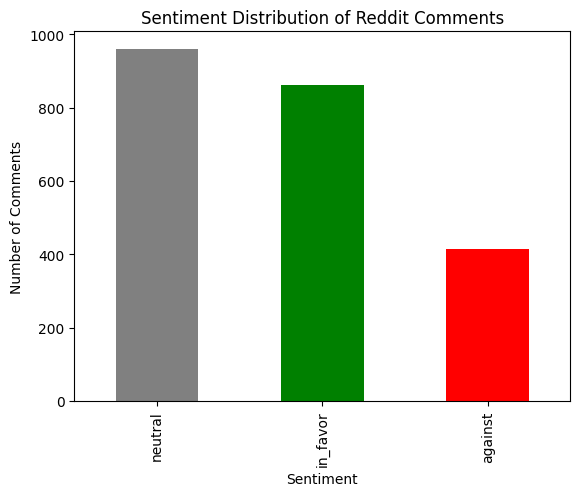

In [24]:
# summary counts
counts = df_comments['sentiment'].value_counts()
print(counts)

# bar chart
counts.plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Sentiment Distribution of Reddit Comments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

### Word clouds
Word clouds show the most common words for each sentiment - bigger words mean higher frequency.

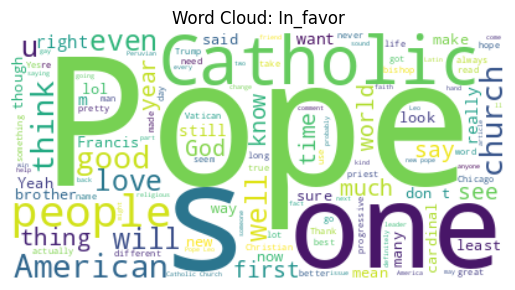

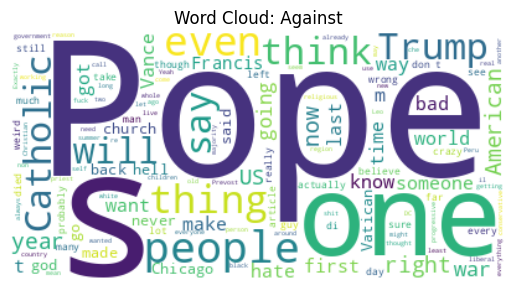

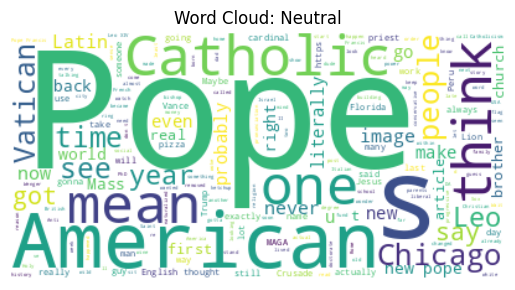

In [25]:
for sentiment in ['in_favor', 'against', 'neutral']:
    text = ' '.join(df_comments[df_comments['sentiment'] == sentiment]['comment'])
    wc = WordCloud(width=400, height=200, background_color='white').generate(text)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {sentiment.capitalize()}')
    plt.show()

### Top words by sentiment
Here are the top 20 words for each sentiment, giving us a deeper DIY, to reveal key themes.

In [26]:
top_words = {}
for sentiment in ['in_favor', 'against', 'neutral']:
    text = ' '.join(df_comments[df_comments['sentiment'] == sentiment]['comment'])
    wc = WordCloud().generate(text)
    freqs = wc.words_
    top = dict(sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:20])
    top_words[sentiment] = top

for sentiment, words in top_words.items():
    df_top = pd.DataFrame.from_dict(words, orient='index', columns=['frequency'])
    df_top.index.name = 'word'
    print(f"Top words for '{sentiment}':")
    display(df_top)

Top words for 'in_favor':


,frequency
word,
Pope,1.000000
s,0.712963
one,0.490741
Catholic,0.476852
people,0.421296
American,0.398148
church,0.375000
think,0.370370
good,0.356481


Top words for 'against':


,frequency
word,
Pope,1.000000
s,0.926829
one,0.536585
people,0.524390
even,0.463415
thing,0.426829
think,0.378049
Catholic,0.378049
Trump,0.378049


Top words for 'neutral':


,frequency
word,
Pope,1.000000
s,0.385965
American,0.350877
Catholic,0.210526
mean,0.210526
think,0.201754
one,0.201754
Chicago,0.184211
people,0.184211


## Interpretation of results

What do these results tell us? Let’s break it down:

- **In Favor**: Supporters celebrate Pope Leo XIV’s American identity as a source of pride and novelty, praising his potential for positive global leadership and drawing hopeful comparisons to Pope Francis. Their endorsements are thoughtful and engaged.
- **Against**: Critics express strong disapproval, often rooted in frustration with his background (especially his American and Chicago ties) and concerns about the changes he might bring. Opposition is emotionally charged and polarized.
- **Neutral**: Neutral users focus on factual details like his American and Peruvian heritage, highlighting the novelty of his papacy while maintaining a curious, wait-and-see attitude.

### Key Insights
- American Identity is Central: His nationality drives pride, critique, and curiosity across all sentiments.
- Supporters See Global Potential: They emphasize leadership and continuity with Pope Francis.
- Critics Are Polarized: Opposition is marked by strong emotions and concerns about his background.
- Neutrals Focus on Novelty: They observe his unique profile with interest but remain uncommitted.

## Clean up
We close the browser to free up resources.

In [27]:
driver.quit()

## Final Thoughts

This analysis shows how Reddit reacts to Pope Leo XIV: pride, skepticism, and curiosity dominate the conversation. For my blog readers, this peek into public sentiment highlights why online opinions matter. Stay tuned for more data-driven explorations!

>Limitations: This is a basic analysis—more comments or advanced methods could deepen the insights.